In [2]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
import copy


In [3]:
figsize = (16,8) #figsize in inches. 

In [4]:
t_cyclus = (4*60 + 1)*60 #de cyclus op de raspi liep voor 1 minuut zonder vermogen. 2 uur non cycling, 2 uur full cycling.  

In [8]:
#filenames
root = "CSV_files/"
Test1_1_txt = root + "TEST1_1_COOLED_WITHFAN.csv"
Test2_1_txt = root + "Test2_1_cooled_withoutfan.csv"
Test3_2_txt = root + "TEST3_2_withfan_nocooling_newambient.csv"
Test4_1_txt = root + "TEST4_1_withoutfan_nocooling_newambient3.csv"
Test5_1_txt = root + "TEST5_1_withfan_cooling_newambient3.csv"

In [9]:
Test1_1 = pd.read_csv(Test1_1_txt, sep=';', index_col=0).replace(',','.', regex=True).convert_objects(convert_numeric=True)
Test2_1 = pd.read_csv(Test2_1_txt, sep=';', index_col=0).replace(',','.', regex=True).convert_objects(convert_numeric=True)
Test3_2 = pd.read_csv(Test3_2_txt, sep=';', index_col=0).replace(',','.', regex=True).convert_objects(convert_numeric=True)
Test4_1 = pd.read_csv(Test4_1_txt, sep=';', index_col=0).replace(',','.', regex=True).convert_objects(convert_numeric=True)
Test5_1 = pd.read_csv(Test5_1_txt, sep=';', index_col=0).replace(',','.', regex=True).convert_objects(convert_numeric=True)

/home/jgrietens/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.
/home/jgrietens/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
/home/jgrietens/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  

In [10]:
print("Test1_1.shape: ", Test1_1.shape, str(Test1_1.shape[0]/60/60) + " h ")
print("Test2_1.shape: ", Test2_1.shape, str(Test2_1.shape[0]/60/60) + " h ")
print("Test3_2.shape: ", Test3_2.shape, str(Test3_2.shape[0]/60/60) + " h ")
print("Test4_1.shape: ", Test4_1.shape, str(Test4_1.shape[0]/60/60) + " h ")
print("Test5_1.shape: ", Test5_1.shape, str(Test5_1.shape[0]/60/60) + " h ")

Test1_1.shape:  (14548, 9) 4.041111111111111 h 
Test2_1.shape:  (63444, 9) 17.623333333333335 h 
Test3_2.shape:  (14497, 10) 4.026944444444444 h 
Test4_1.shape:  (15138, 10) 4.205 h 
Test5_1.shape:  (28801, 10) 8.000277777777777 h 


In [11]:
Test1_1.plot(title="Test1_1")
Test2_1.plot(title="Test2_1")
Test3_2.plot(title="Test3_2")
Test4_1.plot(title="Test4_1")
Test5_1.plot(title="Test5_1")

# TEST 4_1 | NOT COOLED | NO FAN

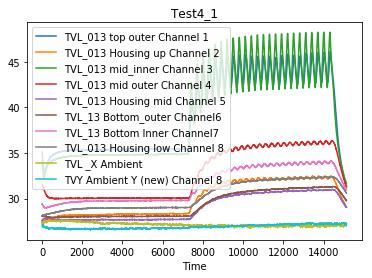

In [12]:
Test4_1.plot(title="Test4_1")

Deze meting werd uitgevoerd onder een timer, de meting werd gelimiteerd op 8 uur en de cyclus begon pas 3 uur na de meting.

In [9]:
t_dead = 20                             #seconden voor raspi cyclus begon te lopen
t_start= t_dead
t_end_sleep= t_start+ 1*60                    # end of the 1 minute measurement without power. 
t_end_steady= t_end_sleep + 2 * 60 * 60       #end of the 2h steady power
t_stop= t_end_steady + 2 * 60 * 60                        #end of the 2h of cycling power



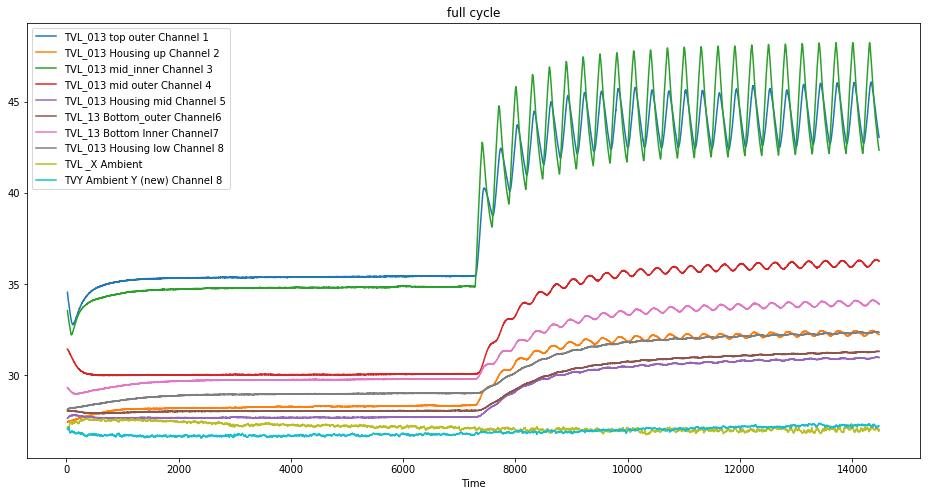

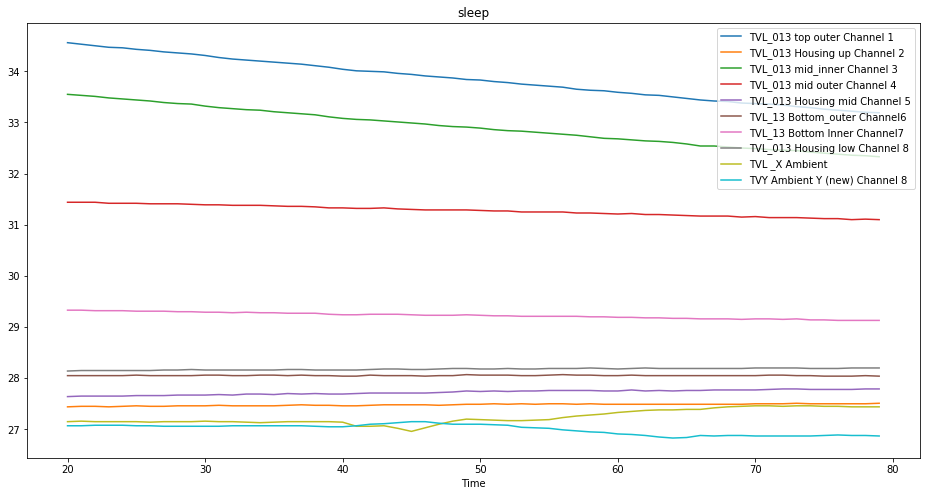

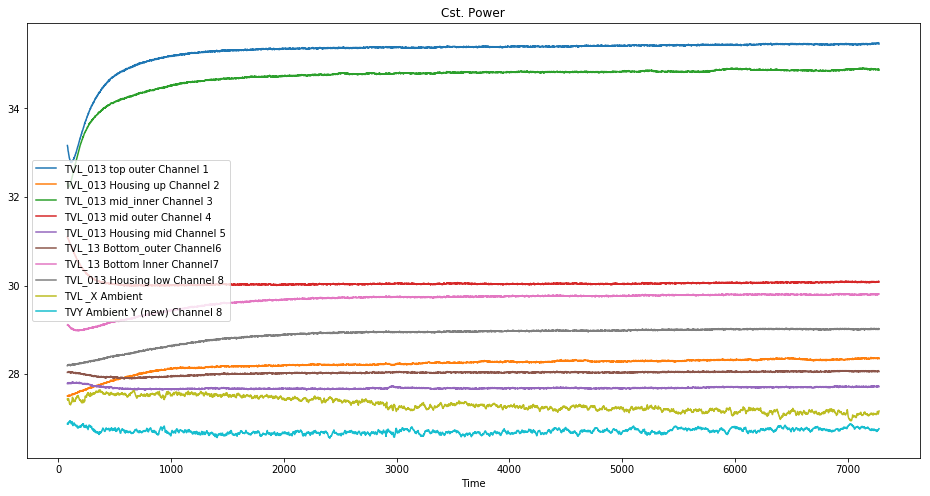

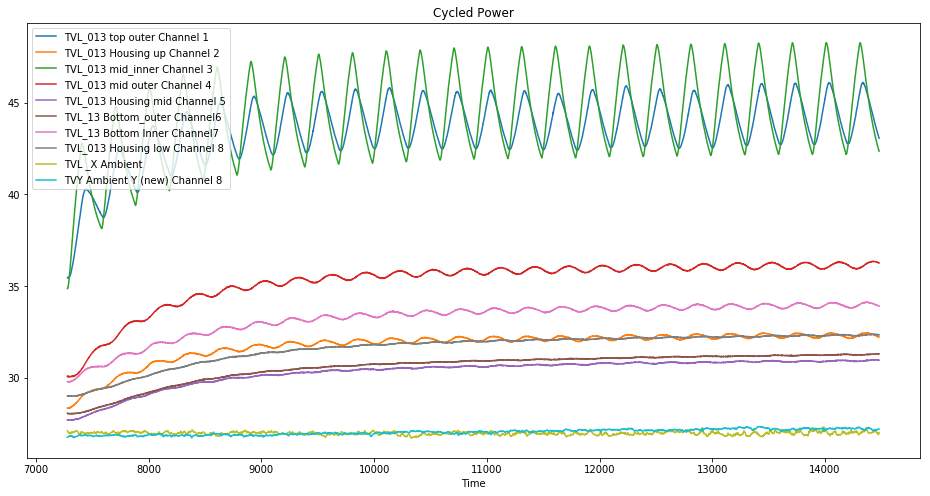

In [10]:
Test4_1_full_cycle= Test4_1.iloc[t_start:t_stop]
Test4_1_sleep= Test4_1.iloc[t_start:t_end_sleep]
Test4_1_cstpower= Test4_1.iloc[t_end_sleep:t_end_steady]
Test4_1_cycledpower= Test4_1.iloc[t_end_steady:t_stop]

Test4_1_full_cycle.plot(title="full cycle",figsize = figsize)
Test4_1_sleep.plot(title="sleep",figsize = figsize)
Test4_1_cstpower.plot(title="Cst. Power",figsize = figsize)
Test4_1_cycledpower.plot(title="Cycled Power",figsize = figsize)

## Model training on cst power part. 

We starten met gemakkelijkste case. Dit is de case met uncycled power omdat deze minder varierend is. Dit is de non-cooled versie omdat we dan geen cool cyclus terug zien in het signaal. 

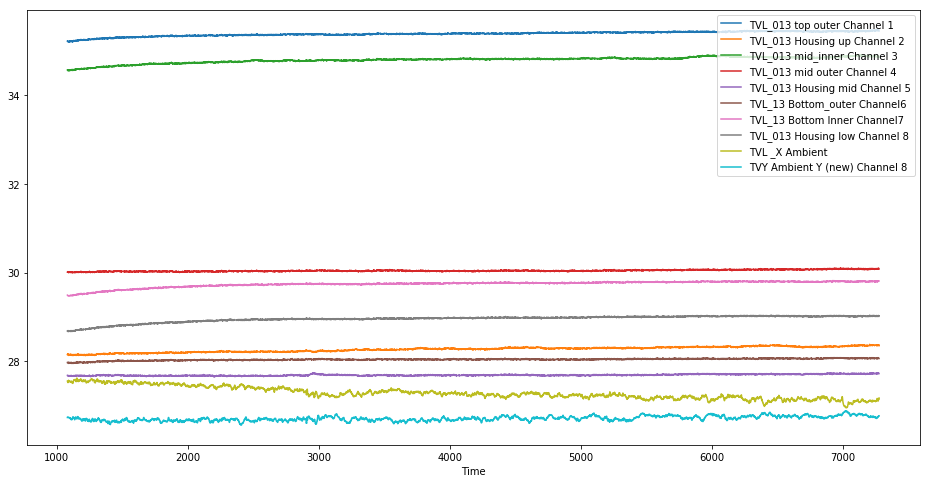

In [11]:
#Croppen van om het meest constante signaal te selecteren uit Test4_1_cstpower
Test4_1_cstpower_cropped = Test4_1_cstpower.iloc[1000:]
Test4_1_cstpower_cropped.plot(figsize = figsize)


In [12]:
#Opsplitsen in training set en validatie set

In [13]:
procent_split = 0.30 # 70-30% split.  

In [18]:
l_df = Test4_1_cstpower_cropped.shape[0] #length of the dataframe
index_start_train = Test4_1_cstpower_cropped.index[0]
index_stop_train = int(index_start_train+(1-procent_split)*l_df)


Test4_1_cstpower_train = Test4_1_cstpower_cropped.iloc[index_start_train:index_stop_train]
Test4_1_cstpower_valid = Test4_1_cstpower_cropped.iloc[index_stop_train+1:]

colnum = Test4_1_cstpower_train.shape[1] #number of columns



In [19]:
colnum

10

### Model training/validation on P_cst

In [20]:
x_train = Test4_1_cstpower_train.iloc[:,0:colnum-2]
y_train = Test4_1_cstpower_train.iloc[:,9:10]

x_valid = Test4_1_cstpower_valid.iloc[:,0:colnum-2]
y_valid = Test4_1_cstpower_valid.iloc[:,9:10]

ols = linear_model.LinearRegression()

model = ols.fit(x_train, y_train)

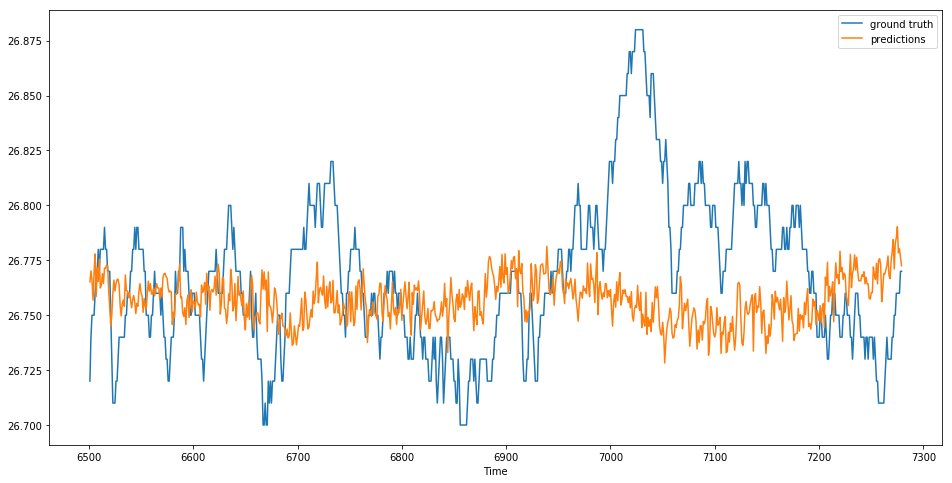

In [21]:
#prediction
pred_val = model.predict(x_valid)
#red_val = pd.DataFrame(pred_val)

y_comparison = copy.copy(y_valid)
y_comparison.rename(columns={'TVY Ambient Y (new) Channel 8': 'ground truth'}, inplace = True)
y_comparison['predictions'] = pred_val


y_comparison.plot(figsize=figsize)

In [22]:
#Coefficients and matching values in the model.
coef = model.coef_[0].tolist() #model coefficients
index_labels = Test4_1_cstpower_train.iloc[:,0:colnum-2].columns.values.tolist()
coef_unsort = pd.DataFrame(coef, index = index_labels, columns = ['coefficient'])
coef_sort = coef_unsort.sort_values('coefficient')
print(coef_unsort)
print(coef_sort)


                               coefficient
TVL_013 top outer Channel 1       0.396196
TVL_013 Housing up Channel 2      0.187008
TVL_013 mid_inner Channel 3      -0.500682
TVL_013 mid outer Channel 4       0.197956
TVL_013 Housing mid Channel 5     0.550187
TVL_13 Bottom_outer Channel6     -0.140102
TVL_13 Bottom Inner Channel7      0.265229
TVL_013 Housing low Channel 8     0.407289
                               coefficient
TVL_013 mid_inner Channel 3      -0.500682
TVL_13 Bottom_outer Channel6     -0.140102
TVL_013 Housing up Channel 2      0.187008
TVL_013 mid outer Channel 4       0.197956
TVL_13 Bottom Inner Channel7      0.265229
TVL_013 top outer Channel 1       0.396196
TVL_013 Housing low Channel 8     0.407289
TVL_013 Housing mid Channel 5     0.550187


Het is niet onlogisch dat er enkele waarden negatief zijn. Het lijkt er op dat een hoge temperatuur kort bij de CPU negatief bijdraagt aan de echte temperatuur. Dit lijkt logisch aangezien een hoge waarde hier zou bijdragen aan een overschatting. 

TODO !! It might be usefull to remove measurement points that have very similar values because they might have oposite coefficient that are too large to counteract each other. 

In [23]:
#Calculating a score.
#Mean absolute error regression loss.
error = mean_absolute_error(y_true = y_valid.as_matrix(), y_pred = pred_val)
print('The mean absolute error is %f' %error)

The mean absolute error is 0.031297


 ## validate model that was trained on P_cst on P_var

In [24]:
x_valid_var = Test4_1_cycledpower.iloc[:,0:colnum-2]
y_valid_var = Test4_1_cycledpower.iloc[:,9:10]

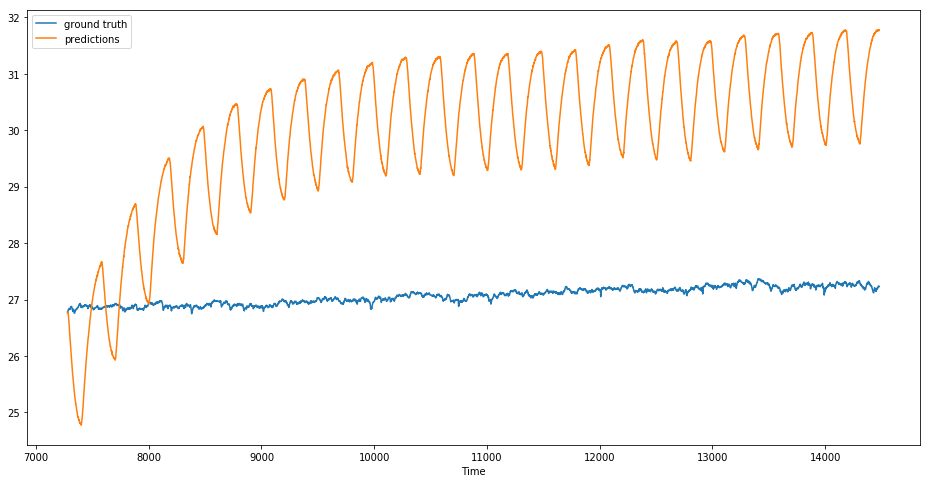

In [25]:
#prediction
pred_val = model.predict(x_valid_var)
#red_val = pd.DataFrame(pred_val)

y_comparison = copy.copy(y_valid_var)
y_comparison.rename(columns={'TVY Ambient Y (new) Channel 8': 'ground truth'}, inplace = True)
y_comparison['predictions'] = pred_val


y_comparison.plot(figsize=figsize)

In [26]:
pred_val = model.predict(x_valid_var)

In [27]:
type(pred_val)

numpy.ndarray

In [28]:
#Calculating a score.
#Mean absolute error regression loss.
error = mean_absolute_error(y_true = y_valid_var.as_matrix(), y_pred = pred_val)
print('The mean absolute error is %f' %error)


The mean absolute error is 3.009053


## Validate model that was trained on P_var and validated on a piece of P_Cst & P_var

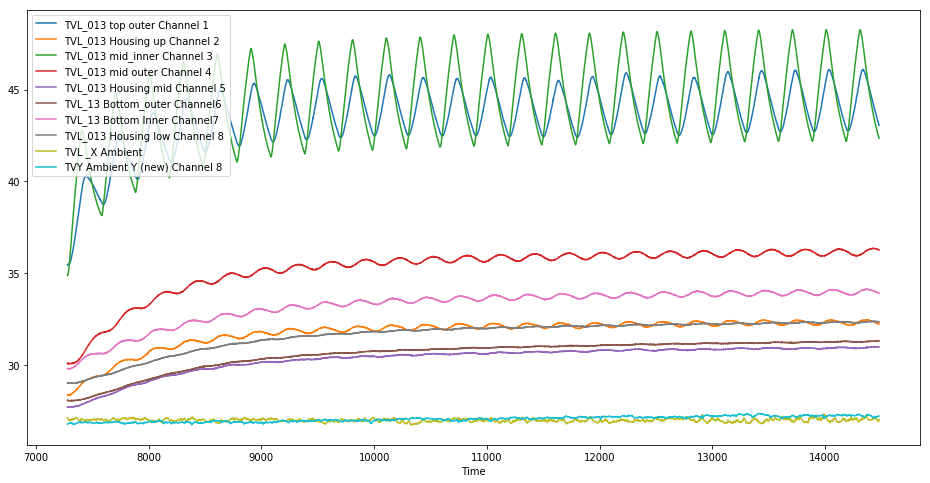

In [29]:
#Croppen van om het meest constante signaal te selecteren uit Test4_1_cstpower
Test4_1_cycledpower_cropped = Test4_1_cycledpower #doesn't need cropping
Test4_1_cycledpower_cropped.plot(figsize = figsize)


In [30]:
#Opsplitsen in training set en validatie set

In [31]:
procent_split = 0.30 # 70-30% split.  

In [33]:
l_df = Test4_1_cycledpower_cropped.shape[0] #length of the dataframe
index_start_train = 0
index_stop_train = int((1-procent_split)*l_df)


Test4_1_cycledpower_train = Test4_1_cycledpower_cropped.iloc[index_start_train:index_stop_train]
Test4_1_cycledpower_valid = Test4_1_cycledpower_cropped.iloc[index_stop_train+1:]

colnum = Test4_1_cycledpower_train.shape[1] #number of columns

### Training and validating on P_var

In [34]:
x_train = Test4_1_cycledpower_train.iloc[:,0:colnum-2]
y_train = Test4_1_cycledpower_train.iloc[:,9:10]

x_valid = Test4_1_cycledpower_valid.iloc[:,0:colnum-2]
y_valid = Test4_1_cycledpower_valid.iloc[:,9:10]

ols = linear_model.LinearRegression()

model = ols.fit(x_train, y_train)

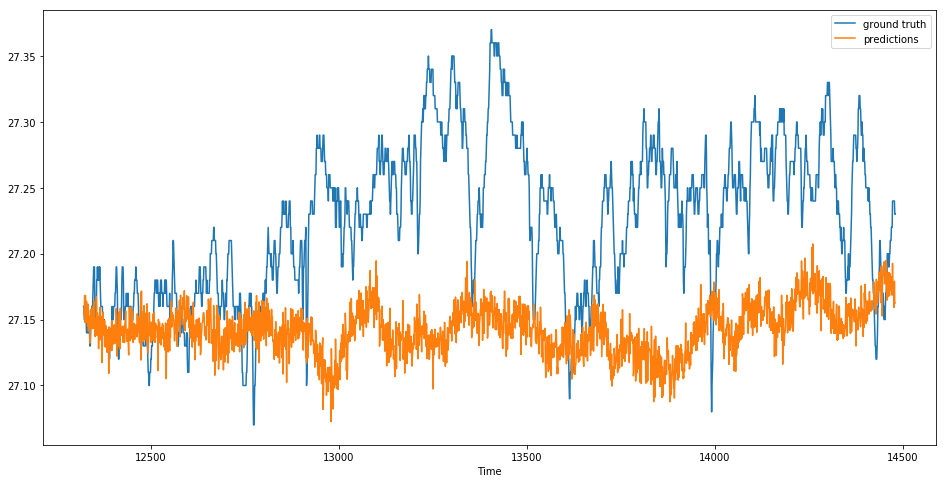

In [35]:
#prediction
pred_val = model.predict(x_valid)
#red_val = pd.DataFrame(pred_val)

y_comparison = copy.copy(y_valid)
y_comparison.rename(columns={'TVY Ambient Y (new) Channel 8': 'ground truth'}, inplace = True)
y_comparison['predictions'] = pred_val


y_comparison.plot(figsize=figsize)

In [36]:
#Coefficients and matching values in the model.
coef = model.coef_[0].tolist() #model coefficients
index_labels = Test4_1_cycledpower_train.iloc[:,0:colnum-2].columns.values.tolist()
coef_unsort = pd.DataFrame(coef, index = index_labels, columns = ['coefficient'])
coef_sort = coef_unsort.sort_values('coefficient')
print(coef_unsort)
print(coef_sort)


                               coefficient
TVL_013 top outer Channel 1      -0.046789
TVL_013 Housing up Channel 2     -1.022998
TVL_013 mid_inner Channel 3       0.034196
TVL_013 mid outer Channel 4       0.063739
TVL_013 Housing mid Channel 5     1.366389
TVL_13 Bottom_outer Channel6     -0.755571
TVL_13 Bottom Inner Channel7      1.010169
TVL_013 Housing low Channel 8    -0.646793
                               coefficient
TVL_013 Housing up Channel 2     -1.022998
TVL_13 Bottom_outer Channel6     -0.755571
TVL_013 Housing low Channel 8    -0.646793
TVL_013 top outer Channel 1      -0.046789
TVL_013 mid_inner Channel 3       0.034196
TVL_013 mid outer Channel 4       0.063739
TVL_13 Bottom Inner Channel7      1.010169
TVL_013 Housing mid Channel 5     1.366389


In [37]:
#Calculating a score.
#Mean absolute error regression loss.
error = mean_absolute_error(y_true = y_valid.as_matrix(), y_pred = pred_val)
print('The mean absolute error is %f' %error)

The mean absolute error is 0.087077


### Validate the model that was trained on the P_var data on the p_cst training data

In [43]:
x_valid = Test4_1_cstpower_train.iloc[:,0:colnum-2] #x_train van vorige deel. 
y_valid = Test4_1_cstpower_train.iloc[:,9:10]


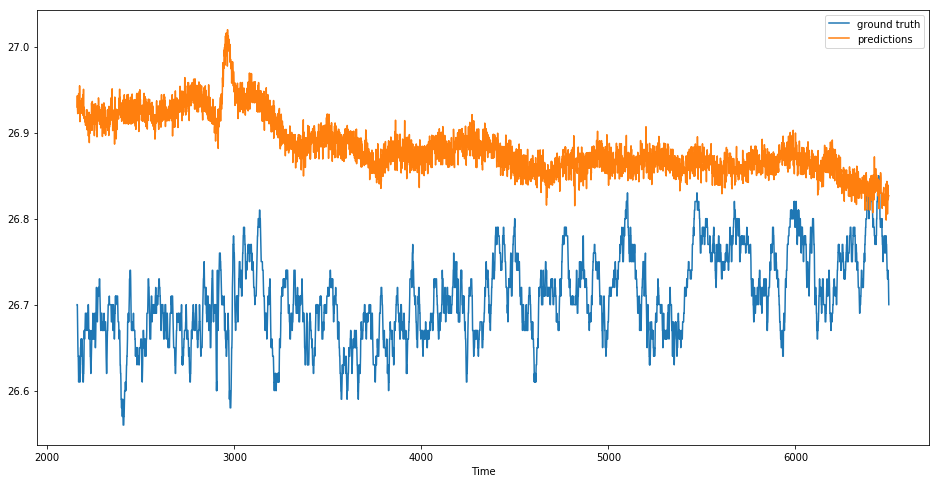

In [44]:
#prediction
pred_val = model.predict(x_valid)
#red_val = pd.DataFrame(pred_val)

y_comparison = copy.copy(y_valid)
y_comparison.rename(columns={'TVY Ambient Y (new) Channel 8': 'ground truth'}, inplace = True)
y_comparison['predictions'] = pred_val


y_comparison.plot(figsize=figsize)

In [45]:
pred_val = model.predict(x_valid)

In [46]:
type(pred_val)

numpy.ndarray

In [47]:
#Calculating a score.
#Mean absolute error regression loss.
error = mean_absolute_error(y_true = y_valid.as_matrix(), y_pred = pred_val)
print('The mean absolute error is %f' %error)


The mean absolute error is 0.176217


# TEST 1_1 | COOLED | FAN

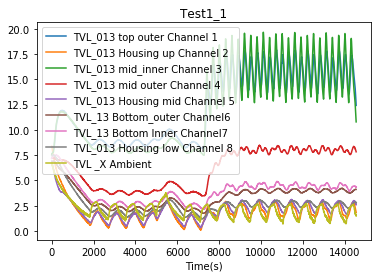

In [13]:
Test1_1.plot(title="Test1_1")

Deze meting werd uitgevoerd onder een timer, de meting werd gelimiteerd op 8 uur en de cyclus begon pas 3 uur na de meting.

In [ ]:
t_dead = 20                             #seconden voor raspi cyclus begon te lopen
t_start= t_dead
t_end_sleep= t_start+ 1*60                    # end of the 1 minute measurement without power. 
t_end_steady= t_end_sleep + 2 * 60 * 60       #end of the 2h steady power
t_stop= t_end_steady + 2 * 60 * 60                        #end of the 2h of cycling power



In [ ]:
Test1_1_full_cycle= Test1_1.iloc[t_start:t_stop]
Test1_1_sleep= Test1_1.iloc[t_start:t_end_sleep]
Test1_1_cstpower= Test1_1.iloc[t_end_sleep:t_end_steady]
Test1_1_cycledpower= Test1_1.iloc[t_end_steady:t_stop]

Test1_1_full_cycle.plot(title="full cycle",figsize = figsize)
Test1_1_sleep.plot(title="sleep",figsize = figsize)
Test1_1_cstpower.plot(title="Cst. Power",figsize = figsize)
Test1_1_cycledpower.plot(title="Cycled Power",figsize = figsize)

# TEST 2_1| COOLED | NO FAN

In [ ]:
Test2_1.plot(title="Test2_1", figsize = figsize)

Deze meting werd uitgevoerd onder een timer, de meting werd gelimiteerd op 8 uur en de cyclus begon pas 3 uur na de meting.

In [ ]:
t_dead = 20                             #seconden voor raspi cyclus begon te lopen
t_start= t_dead
t_end_sleep= t_start+ 1*60                    # end of the 1 minute measurement without power. 
t_end_steady= t_end_sleep + 2 * 60 * 60       #end of the 2h steady power
t_stop= t_end_steady + 2 * 60 * 60                        #end of the 2h of cycling power



In [ ]:
Test2_1_full_cycle= Test2_1.iloc[t_start:t_stop]
Test2_1_sleep= Test2_1.iloc[t_start:t_end_sleep]
Test2_1_cstpower= Test2_1.iloc[t_end_sleep:t_end_steady]
Test2_1_cycledpower= Test2_1.iloc[t_end_steady:t_stop]

Test2_1_full_cycle.plot(title="full cycle",figsize = figsize)
Test2_1_sleep.plot(title="sleep",figsize = figsize)
Test2_1_cstpower.plot(title="Cst. Power",figsize = figsize)
Test2_1_cycledpower.plot(title="Cycled Power",figsize = figsize)

In [ ]:
pd.rolling_mean(Test2_1_cstpower['TVL _X Ambient'],3000).plot(figsize=figsize)

In [ ]:
Test2_1_cstpower['TVL _X Ambient'].mean() #.plot(figsize=figsize)

# TEST 3_2 | NOT COOLED | FAN 

In [ ]:
Test3_2.plot(title="Test3_2")

Deze meting werd uitgevoerd onder een timer, de meting werd gelimiteerd op 8 uur en de cyclus begon pas 3 uur na de meting.

In [ ]:
t_dead = 20                             #seconden voor raspi cyclus begon te lopen
t_start= t_dead
t_end_sleep= t_start+ 1*60                    # end of the 1 minute measurement without power. 
t_end_steady= t_end_sleep + 2 * 60 * 60       #end of the 2h steady power
t_stop= t_end_steady + 2 * 60 * 60                        #end of the 2h of cycling power



In [ ]:
Test3_2_full_cycle= Test3_2.iloc[t_start:t_stop]
Test3_2_sleep= Test3_2.iloc[t_start:t_end_sleep]
Test3_2_cstpower= Test3_2.iloc[t_end_sleep:t_end_steady]
Test3_2_cycledpower= Test3_2.iloc[t_end_steady:t_stop]

Test3_2_full_cycle.plot(title="full cycle",figsize = figsize)
Test3_2_sleep.plot(title="sleep",figsize = figsize)
Test3_2_cstpower.plot(title="Cst. Power",figsize = figsize)
Test3_2_cycledpower.plot(title="Cycled Power",figsize = figsize)

# TEST 5_1 | COOLED | FAN

In [ ]:
Test5_1.plot(title="Test5_1")

Deze meting werd uitgevoerd onder een timer, de meting werd gelimiteerd op 8 uur en de cyclus begon pas 3 uur na de meting.

In [ ]:
t_dead = 3*60*60                              #seconden voor raspi cyclus begon te lopen
t_start= t_dead
t_end_sleep= t_start+ 1*60                    # end of the 1 minute measurement without power. 
t_end_steady= t_end_sleep + 2 * 60 * 60       #end of the 2h steady power
t_stop= t_end_steady + 2 * 60 * 60                        #end of the 2h of cycling power



In [ ]:
Test5_1_full_cycle= Test5_1.iloc[t_start:t_stop]
Test5_1_sleep= Test5_1.iloc[t_start:t_end_sleep]
Test5_1_cstpower= Test5_1.iloc[t_end_sleep:t_end_steady]
Test5_1_cycledpower= Test5_1.iloc[t_end_steady:t_stop]

Test5_1_full_cycle.plot(title="full cycle",figsize = figsize)
Test5_1_sleep.plot(title="sleep",figsize = figsize)
Test5_1_cstpower.plot(title="Cst. Power",figsize = figsize)
Test5_1_cycledpower.plot(title="Cycled Power",figsize = figsize)